# Massive Data Analysis
# Ehsan Ghasemi - 98102108
## HW3 - Recommender System 

In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import pandas as pd
from math import sqrt
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import count, lit
from pyspark.sql import functions as F



spark = SparkSession \
    .builder \
    .appName("HW3") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

In [4]:
# import the necessary library
from pyspark.sql.functions import col

# load the data
data = spark.read.json("../../../twitter_data_v2.jsonl")

abas = data

# select the columns
data = data.select(
    "id",
    col("user").getItem("id").alias("user_id"),
    "tweet_type",
    "in_reply_to_status_id_str",
    # "in_reply_to_user_id_str",
    col("quoted_status").getItem("id").alias("quoted_status_id"),
    col("retweeted_status").getItem("id").alias("retweeted_status_id")
)

# show the dataframe
data.show(500)

num_rows = data.count()
num_cols = len(data.columns)

print(f"The DataFrame has {num_rows} rows and {num_cols} columns.")

+-------------------+-------------------+----------+-------------------------+-------------------+-------------------+
|                 id|            user_id|tweet_type|in_reply_to_status_id_str|   quoted_status_id|retweeted_status_id|
+-------------------+-------------------+----------+-------------------------+-------------------+-------------------+
|1736536753815834746|         2808957837| retweeted|                     NULL|               NULL|1736379038376120479|
|1736536756835512564|           22495731| generated|                     NULL|               NULL|               NULL|
|1736536756915249313|          165605880| retweeted|                     NULL|               NULL|1736495024190136471|
|1736536759964512322|1406742149048287242|   replied|      1736356968162378084|               NULL|               NULL|
|1736536759453016510|1726367085377544192| retweeted|                     NULL|               NULL|1736236576517054856|
|1736536759104889128|1254572621208920064| retwee

The DataFrame has 4175860 rows and 6 columns.


In [5]:
# select the first n rows
sampling_data = 5000000
# df = data
df = data.limit(sampling_data)
df.show()

num_rows = df.count()
num_cols = len(df.columns)

print(f"The DataFrame has {num_rows} rows and {num_cols} columns.")

+-------------------+-------------------+----------+-------------------------+-------------------+-------------------+
|                 id|            user_id|tweet_type|in_reply_to_status_id_str|   quoted_status_id|retweeted_status_id|
+-------------------+-------------------+----------+-------------------------+-------------------+-------------------+
|1736536753815834746|         2808957837| retweeted|                     NULL|               NULL|1736379038376120479|
|1736536756835512564|           22495731| generated|                     NULL|               NULL|               NULL|
|1736536756915249313|          165605880| retweeted|                     NULL|               NULL|1736495024190136471|
|1736536759964512322|1406742149048287242|   replied|      1736356968162378084|               NULL|               NULL|
|1736536759453016510|1726367085377544192| retweeted|                     NULL|               NULL|1736236576517054856|
|1736536759104889128|1254572621208920064| retwee

The DataFrame has 4175860 rows and 6 columns.


In [6]:
Th = 550
counts = df.groupBy("user_id").count()

# Filter out user_ids with count less than Th
filtered_counts = counts.filter(F.col("count") >= Th)

# Join back with the original DataFrame
df_greater_than_Th = df.join(filtered_counts, ["user_id"], "inner")

df_greater_than_Th.show()

num_rows = df_greater_than_Th.count()
num_cols = len(df_greater_than_Th.columns)

print(f"The DataFrame has {num_rows} rows and {num_cols} columns.")

+-------------------+-------------------+----------+-------------------------+-------------------+-------------------+-----+
|            user_id|                 id|tweet_type|in_reply_to_status_id_str|   quoted_status_id|retweeted_status_id|count|
+-------------------+-------------------+----------+-------------------------+-------------------+-------------------+-----+
|1001144665175883776|1734405169889026330| retweeted|                     NULL|               NULL|1734080113229050297|  658|
|1001144665175883776|1736375466221801644| retweeted|                     NULL|               NULL|1736117609479782804|  658|
|1001144665175883776|1734405213048496410|    quoted|                     NULL|1734095574515822600|1734096035021004941|  658|
|1001144665175883776|1736375966229012693| retweeted|                     NULL|               NULL|1736051673850691632|  658|
|1001144665175883776|1734405288696938882| retweeted|                     NULL|               NULL|1734248045620174929|  658|


The DataFrame has 305633 rows and 7 columns.


In [7]:


# count the relations for each column and add a new column 'relation_with' to store the column name
relations_id = df_greater_than_Th.groupBy("user_id", "id").count().withColumn("relation_with", lit("id")).withColumn("count", col("count")*1)
# relations_tweet_type = df_greater_than_Th.filter(col("tweet_type").isNotNull()).groupBy("user_id", "tweet_type").count().withColumn("relation_with", lit("tweet_type"))
relations_in_reply_to_status_id_str = df_greater_than_Th.filter(col("in_reply_to_status_id_str").isNotNull()).groupBy("user_id", "in_reply_to_status_id_str").count().withColumn("relation_with", lit("in_reply_to_status_id_str"))
# relations_in_reply_to_user_id_str = df_greater_than_Th.groupBy("user_id", "in_reply_to_user_id_str").count().withColumn("relation_with", lit("in_reply_to_user_id_str"))
relations_quoted_status_id = df_greater_than_Th.filter(col("quoted_status_id").isNotNull()).groupBy("user_id", "quoted_status_id").count().withColumn("relation_with", lit("quoted_status_id"))
relations_retweeted_status_id = df_greater_than_Th.filter(col("retweeted_status_id").isNotNull()).groupBy("user_id", "retweeted_status_id").count().withColumn("relation_with", lit("retweeted_status_id"))



# union all the dataframes
all_relations = relations_id.union(relations_in_reply_to_status_id_str).union(relations_quoted_status_id).union(relations_retweeted_status_id)
# show the relations
all_relations.show(30)

24/01/19 07:23:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------------+-------------------+-----+-------------+
|            user_id|                 id|count|relation_with|
+-------------------+-------------------+-----+-------------+
|1001144665175883776|1734405169889026330|    1|           id|
|1001144665175883776|1736803860747104531|    1|           id|
|1001144665175883776|1734405213048496410|    1|           id|
|1001144665175883776|1736804468732445037|    1|           id|
|1001144665175883776|1734405288696938882|    1|           id|
|1001144665175883776|1736804498650411490|    1|           id|
|1001144665175883776|1734406615510454363|    1|           id|
|1001144665175883776|1736804648516989070|    1|           id|
|1001144665175883776|1734407542057689572|    1|           id|
|1001144665175883776|1736064758900773053|    1|           id|
|1001144665175883776|1734407758332448879|    1|           id|
|1001144665175883776|1736065184844878052|    1|           id|
|1001144665175883776|1734407763550142479|    1|           id|
|1001144

In [8]:
print(type(all_relations))

<class 'pyspark.sql.dataframe.DataFrame'>


In [9]:
all_relations_reduced = all_relations.groupBy("user_id", "id").agg(F.sum("count").alias("count"))

In [10]:
all_relations_reduced.show()

24/01/19 07:25:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:25:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:25:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:25:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:25:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:25:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:25:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:25:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:25:14 WARN RowBasedKeyValueBatch: Calling spill() on

+-------------------+-------------------+-----+
|            user_id|                 id|count|
+-------------------+-------------------+-----+
|1001144665175883776|1734681313909858633|    1|
|1001144665175883776|1734407542057689572|    1|
|1001144665175883776|1736588694944120920|    1|
|1005185803172106241|1735604864011362558|    1|
|1005185803172106241|1735352199377719562|    2|
|1005185803172106241|1736476357457281371|    1|
|1005185803172106241|1735937052766539996|    2|
|1005185803172106241|1735666844076245082|    1|
|1012004974690275329|1735820307116495339|    1|
|1012004974690275329|1735822233560355240|    1|
|1012004974690275329|1735508939276439957|    1|
|1013504202847514625|1736742040153575930|    1|
|1013504202847514625|1735956675993980937|    1|
|1013504202847514625|1735428623518105874|    1|
|1013504202847514625|1735669036124385686|    1|
|1019635645558542338|1734008437481013412|    1|
|1019635645558542338|1734010159444197877|    1|
|1019635645558542338|1734331972489540061

In [11]:
all_relations_reduced_sorted = all_relations_reduced.orderBy("count", ascending=False)

In [13]:
print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [14]:
num_rows = all_relations_reduced_sorted.count()
num_cols = len(all_relations_reduced_sorted.columns)

print(f"The DataFrame has {num_rows} rows and {num_cols} columns.")

24/01/19 07:29:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:29:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:29:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:29:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:29:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:29:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:29:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:29:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:29:23 WARN RowBasedKeyValueBatch: Calling spill() on

The DataFrame has 587033 rows and 3 columns.


In [12]:
all_relations_reduced_sorted.show(5000)

24/01/19 07:27:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:27:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:27:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:27:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:27:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:27:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:27:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:27:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:27:19 WARN RowBasedKeyValueBatch: Calling spill() on

+-------------------+-------------------+-----+
|            user_id|                 id|count|
+-------------------+-------------------+-----+
|1580681279896522753|1735737872467030417|   95|
|1287101616198504448|1736113075911077948|   77|
|1580681279896522753|1733909410185875720|   76|
|1580681279896522753|1735360343747015144|   76|
|1580681279896522753|1734640623880179894|   71|
|           47731642|1736113075911077948|   70|
|1573869416218996741|1735028352220877203|   61|
|1580681279896522753|1736456305164878311|   60|
|1580681279896522753|1735238115571159139|   52|
|1573869416218996741|1735375161078243699|   51|
|1580681279896522753|1736098127361286519|   50|
| 900616625329770497|1736113075911077948|   48|
|1385392925207629827|1735212354583810391|   46|
|         2775317127|1736113075911077948|   46|
|1379823334226071556|1734517585431982482|   45|
|1573869416218996741|1735363990073819591|   44|
|1573869416218996741|1736094665487856046|   41|
|1530063351799091202|1736113075911077948

In [15]:
print(type(all_relations_reduced_sorted))

<class 'pyspark.sql.dataframe.DataFrame'>


In [16]:
pandas_df = all_relations_reduced_sorted.toPandas()

pandas_df.head(50)

24/01/19 07:31:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:31:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:31:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:31:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:31:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:31:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:31:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:31:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/19 07:31:27 WARN RowBasedKeyValueBatch: Calling spill() on

,user_id,id,count
0,1580681279896522753,1735737872467030417,95
1,1287101616198504448,1736113075911077948,77
2,1580681279896522753,1733909410185875720,76
3,1580681279896522753,1735360343747015144,76
4,1580681279896522753,1734640623880179894,71
5,47731642,1736113075911077948,70
6,1573869416218996741,1735028352220877203,61
7,1580681279896522753,1736456305164878311,60
8,1580681279896522753,1735238115571159139,52
9,1573869416218996741,1735375161078243699,51


In [17]:
min_count = pandas_df['count'].min()
max_count = pandas_df['count'].max()

pandas_df['count_scaled'] = (pandas_df['count'] - min_count) / (max_count - min_count)

pandas_df.head(50)

,user_id,id,count,count_scaled
0,1580681279896522753,1735737872467030417,95,1.000000
1,1287101616198504448,1736113075911077948,77,0.808511
2,1580681279896522753,1733909410185875720,76,0.797872
3,1580681279896522753,1735360343747015144,76,0.797872
4,1580681279896522753,1734640623880179894,71,0.744681
5,47731642,1736113075911077948,70,0.734043
6,1573869416218996741,1735028352220877203,61,0.638298
7,1580681279896522753,1736456305164878311,60,0.627660
8,1580681279896522753,1735238115571159139,52,0.542553
9,1573869416218996741,1735375161078243699,51,0.531915


In [18]:
pivot_table = pandas_df.pivot(index='user_id', columns='id', values='count_scaled')

pivot_table

ratings_df = pivot_table

ratings_df

id,1002869867794575360,1003946830055591936,1005498894229430272,1010085769829109760,1010145729074073600,1010617663230500868,1013240061448675329,1014428487501996032,1015604540471726081,1015604551053971456,...,973084284587270144,973084287967821824,973270750034583552,979644056216186881,988129980713525249,988526205979824129,989967503626506240,991349546713272321,993920789144621057,995045044905234432
user_id,,,,,,,,,,,,,,,,,,,,,
1001144665175883776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005185803172106241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1012004974690275329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013504202847514625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1019635645558542338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990379588147666945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992150922926084096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
995173233610690560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
column_ids = pivot_table.columns
column_ids_series = pd.Series(pivot_table.columns)

# Convert to a DataFrame
column_ids_df = pd.DataFrame(pivot_table.columns)

column_ids_df

artists = column_ids_df
artists

,id
0,1002869867794575360
1,1003946830055591936
2,1005498894229430272
3,1010085769829109760
4,1010145729074073600
...,...
412599,988526205979824129
412600,989967503626506240
412601,991349546713272321
412602,993920789144621057


In [20]:
ratings = pivot_table.fillna(0)

ratings

id,1002869867794575360,1003946830055591936,1005498894229430272,1010085769829109760,1010145729074073600,1010617663230500868,1013240061448675329,1014428487501996032,1015604540471726081,1015604551053971456,...,973084284587270144,973084287967821824,973270750034583552,979644056216186881,988129980713525249,988526205979824129,989967503626506240,991349546713272321,993920789144621057,995045044905234432
user_id,,,,,,,,,,,,,,,,,,,,,
1001144665175883776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005185803172106241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1012004974690275329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013504202847514625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1019635645558542338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990379588147666945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
992150922926084096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995173233610690560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
print(f'{np.mean((ratings != 0).to_numpy()) * 100} % of the above dataframe is filled')


0.015498882342047961 % of the above dataframe is filled


In [22]:
MIN_USER_RATINGS = 20
DELETE_RATING_COUNT = 5

def train_test_split(ratings):
    
    train = ratings.to_numpy()
    validation = np.zeros(train.shape)
    
    idx_user = np.where(np.linalg.norm(train, ord=0, axis=1) >= MIN_USER_RATINGS)[0]
    
    for i in idx_user:
        idx_artist = np.where(train[i, :] != 0)[0]
        remove_idx = np.random.choice(idx_artist, DELETE_RATING_COUNT)
        validation[i, remove_idx] = train[i, remove_idx]
        train[i, remove_idx] = 0
    
    return train, validation

In [23]:
train, val = train_test_split(ratings)

In [24]:

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth != 0]
    ground_truth = ground_truth[ground_truth != 0]
    return sqrt(mean_squared_error(prediction, ground_truth))

In [25]:
class Recommender:
  
    def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
        self.n_epochs = n_epochs
        self.n_latent_features = n_latent_features
        self.lmbda = lmbda
        self.learning_rate = learning_rate
  
    def predictions(self, P, Q):
        return P.T @ Q
  
    def fit(self, X_train, X_val):
        nu, ni = X_train.shape
        P = np.random.randn(self.n_latent_features, nu)
        Q = np.random.randn(self.n_latent_features, ni)
        self.train_loss = []
        self.val_loss = []
        nonzero_idx = np.nonzero(X_train)
        
        for epoch in tqdm(range(self.n_epochs)):
            for u, i in zip(*nonzero_idx):
                e_ui = X_train[u, i] - np.dot(Q[:, i], P[:, u])
                Q[:, i] += self.learning_rate * (e_ui*P[:, u] - self.lmbda*Q[:, i])
                P[:, u] += self.learning_rate * (e_ui*Q[:, i] - self.lmbda*P[:, u])
                
            my_predictions = self.predictions(P, Q)
            self.train_loss.append(rmse(my_predictions, X_train))
            self.val_loss.append(rmse(my_predictions, X_val))
        
        self.optimal_P = P
        self.optimal_Q = Q
        
        return self

    def predict(self, X_train, user_index):
        predict_user = self.optimal_Q.T @ self.optimal_P[:, user_index]
        predict_user = predict_user[X_train[user_index, :] == 0]
        #predict_user = predict_user.flatten()
        #predict_user[X_train[user_index, :] != 0] = X_train[user_index, X_train[user_index, :] != 0]
        return predict_user

In [26]:
#creating recommender object
recommender = Recommender(n_epochs=200, n_latent_features=10, lmbda=0.05, learning_rate=0.01).fit(train, val)

  0%|          | 0/200 [00:00<?, ?it/s]

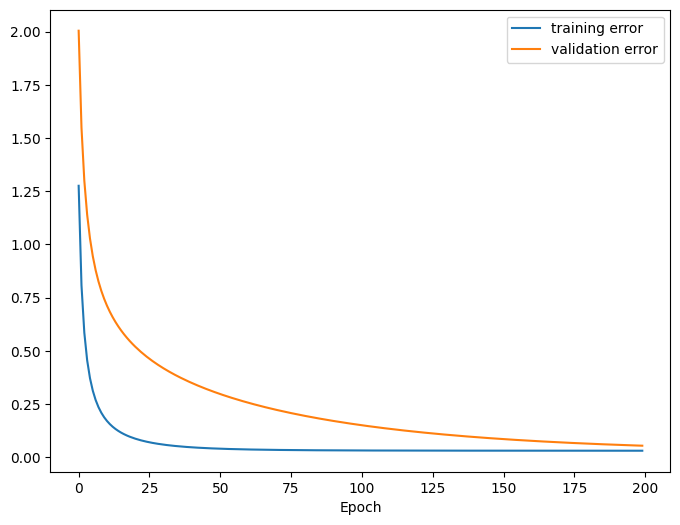

In [27]:

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(recommender.n_epochs), recommender.train_loss, label='training error')
ax.plot(range(recommender.n_epochs), recommender.val_loss, label='validation error')
ax.set_xlabel('Epoch')
plt.legend();

In [28]:
recommender.train_loss[-1], recommender.val_loss[-1]

(0.030925130904616113, 0.05454128143046658)

In [29]:
user_id = '1013504202847514625'
user_index = ratings_df.index.get_loc(user_id)
predictions_index = np.where(train[user_index, :] == 0)[0]
rating_predictions = recommender.predict(train, user_index)

In [30]:
def create_artist_ratings(artists_df, artists_index, ratings, n=100):
    artist_ids = ratings_df.columns[artists_index]
    artist_ratings = pd.DataFrame(data=dict(artistId=artist_ids, rating=ratings))
    top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(n)
    
    artist_recommendations = artists_df.merge(top_n_artists, how='right', right_on='artistId', left_on='id')
    artist_recommendations.drop(columns=['artistId'], inplace=True)
    return artist_recommendations.sort_values("rating", ascending=False)

In [31]:
existing_ratings_index = np.where(train[user_index, :] > 0)[0]
existing_ratings = train[user_index, existing_ratings_index]

create_artist_ratings(artists, existing_ratings_index, existing_ratings)

,id,rating
0,1735369823490617391,0.031915
1,1735390914850283825,0.021277
14,1735643282971963607,0.010638
25,1733185378251583745,0.010638
24,1733881573756281080,0.010638
23,1734200974984773997,0.010638
22,1734203630985814175,0.010638
21,1735168288613859665,0.010638
20,1735179987618291919,0.010638
19,1735322777190576383,0.010638
